In [5]:
import pandas as pd
import numpy as np

In [6]:
# Unzip the data in the Google Drive
# !unzip "/content/drive/MyDrive/Dog_Vision/test.zip" -d "/content/drive/MyDrive/Dog_Vision/test/"

## 🐶 End-to-end multi-class Dog Breed Classification
This notebook builds an end-to-end multi-class image classifier using Tensorflow 2.15 and Tensorflow Hub

#### 1. Problem
Identifying the breed of a dog given an image of a dog.

#### 2. Data
The data we're using is from Kaggle's Dog Breed Identification competition

https://www.kaggle.com/c/dog-breed-identification/data

#### 3. Evaluation
The evaluation is a file with prediction possibilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview

#### 4. Features
- We are dealing with images(Unstructured data) so it's probably best we use deep learning / transfer learning.
- There are 120 breeds of dogs (this means there are 120 different classes).
- There are 10,000+ images in the training set (these images have labels)
- There are 10,000+ images in the test set (these images have no labels, because we want to predict them).

### Get our workspace ready
- Import Tensorflow ✅
- Import Tensorflow Hub (to pick our model from) ✅
- Make sure we're using a GPU ✅

In [7]:
import tensorflow as tf
import tensorflow_hub as hub

TensorFlow Hub is a repository of trained machine learning models.

In [8]:
print("TensorFlow Version:" ,tf.__version__)
print("TensorFlow HUB Version:" ,hub.__version__)

TensorFlow Version: 2.15.0
TensorFlow HUB Version: 0.16.1


In [9]:
# Check for GPU availability
print("GPU", "available") if tf.config.list_physical_devices("GPU") else "Not available"

'Not available'

### Getting our data ready (turning into tensors)
Turning our images into Tensors (numerical representation). Let's start by accessing our data and checking out the labels

In [10]:
labels_csv = pd.read_csv("/content/drive/MyDrive/Dog_Vision/labels.csv")

In [11]:
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126

In [12]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [13]:
# How many images are there of each breed?
labels_csv.breed.value_counts()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64

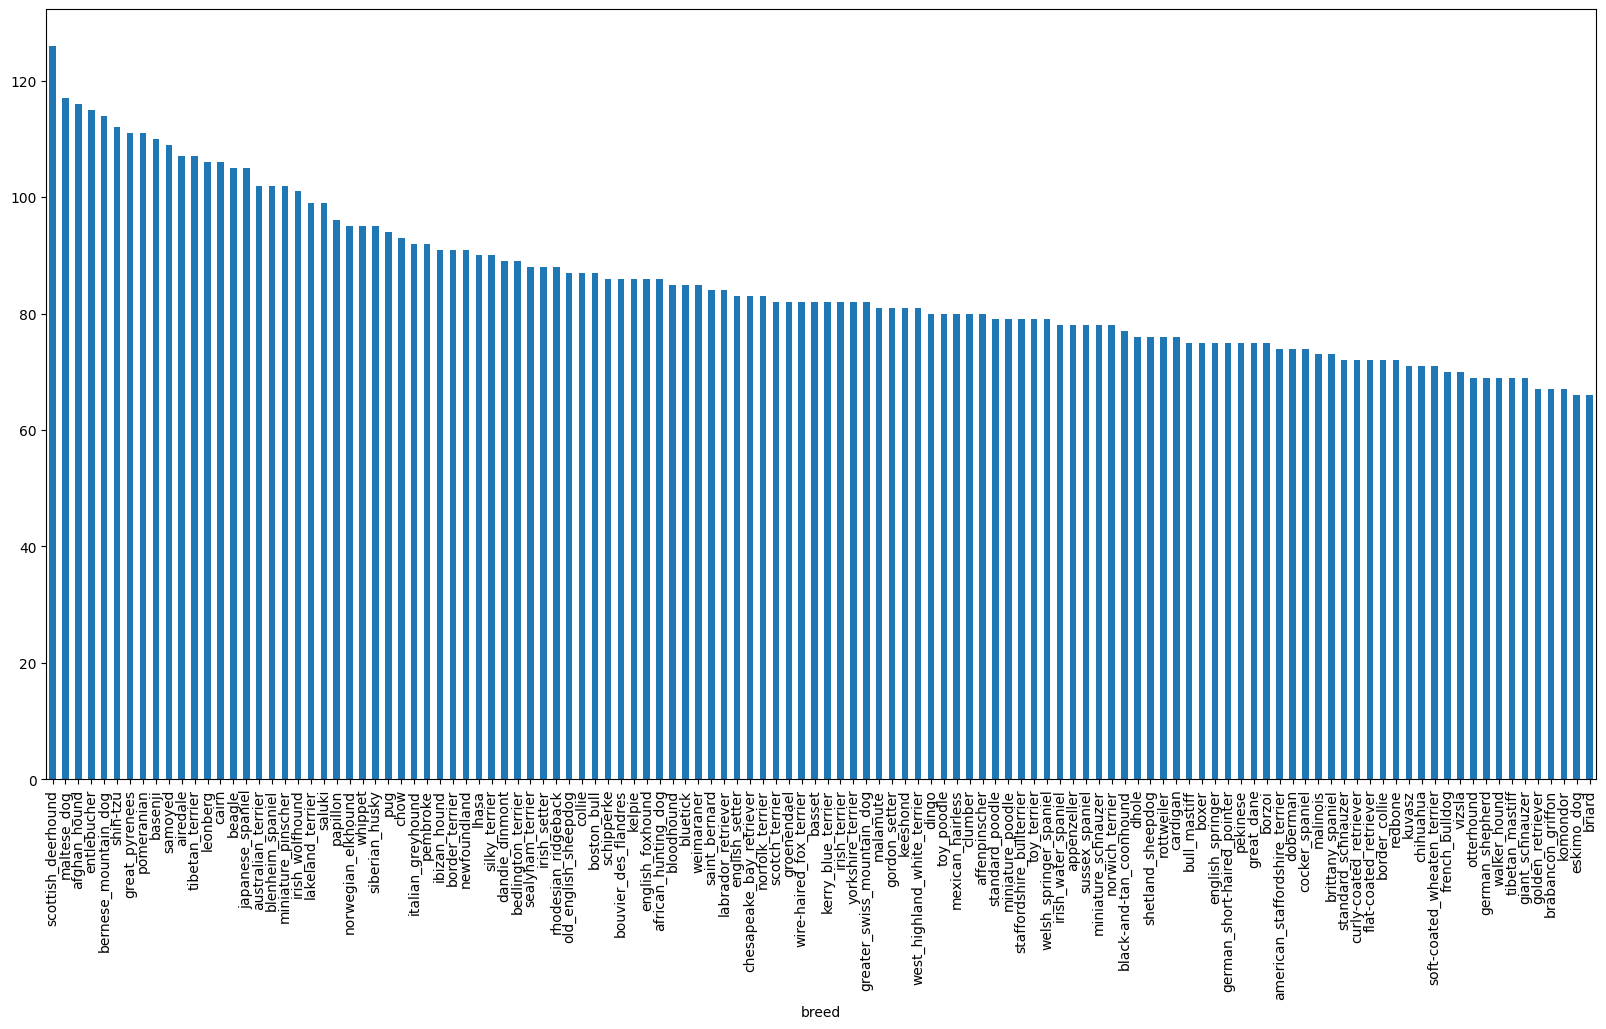

In [14]:
labels_csv.breed.value_counts().plot.bar(figsize=(20,10));

In [15]:
labels_csv.breed.value_counts().median()

82.0

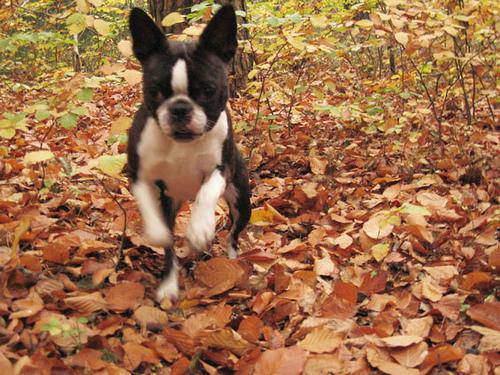

In [16]:
#  Let's view an image
from IPython.display import Image
Image("/content/drive/MyDrive/Dog_Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

#### Getting images and their labels
Let's get a list of all our image file path names

In [17]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [18]:
filenames = ["drive/MyDrive/Dog_Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['drive/MyDrive/Dog_Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog_Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog_Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog_Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog_Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog_Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog_Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog_Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog_Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog_Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [19]:
len(filenames)

10222

In [20]:
# Check whether no. of filenames matches no. of actual image files
import os
if len(os.listdir("drive/MyDrive/Dog_Vision/train/"))==len(filenames):
    print("Filenames match actual amount of files!! Proceed")
else:
    print("Filenames do not match actual amount of files, check the target directory")

Filenames match actual amount of files!! Proceed


In [21]:
os.listdir("drive/MyDrive/Dog_Vision/train/")[:10]

['e6eb11571ef963fac4d2300df3122f85.jpg',
 'e792459978c605f740a2b553ec1608f6.jpg',
 'e7ab11f849e895ced3cdddf4d90e5bd2.jpg',
 'e76687c549303fb57aae9866739f44b8.jpg',
 'e7bc17ef352ef576b73467ebe9a407f1.jpg',
 'e779a2c3d07afb0056a1e33298e9eecf.jpg',
 'e6e89b7a7579de5c5ced94253491953e.jpg',
 'e7f2f67cb616281a89fc77a6bdea6eb0.jpg',
 'e75f2316c5dd47b87a22bbe95cf8b8da.jpg',
 'e7af30693df78697b8541fb5e2e46941.jpg']

In [22]:
len(os.listdir("drive/MyDrive/Dog_Vision/train/"))

10222

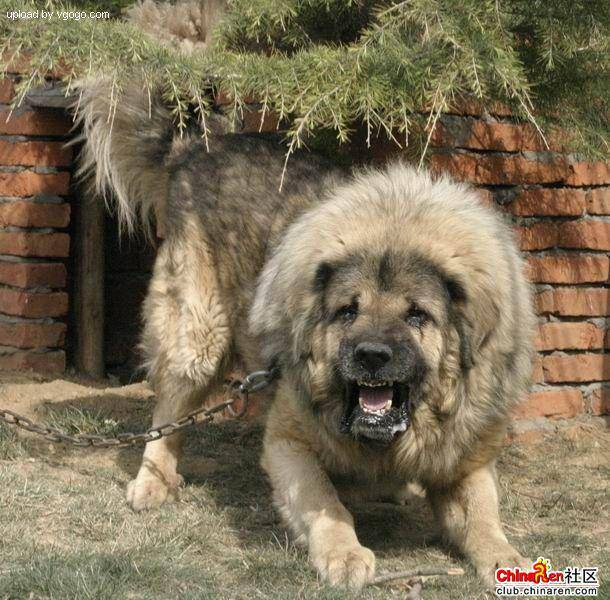

In [23]:
Image(filenames[9000])

In [24]:
labels_csv['breed'][9000]

'tibetan_mastiff'

In [25]:
len(os.listdir("drive/MyDrive/Dog_Vision/test/"))

10357

Since we have our training image filepaths in a list. Let's prepare our labels.

In [26]:
labels = labels_csv['breed'].to_numpy()
# labels = np.array(labels) # Does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [27]:
len(labels)

10222

In [28]:
# See if number of labels matches no. of filenames
if len(labels)==len(filenames):
    print("Both matches!!")
else:
    print("Not matching, check data directory")

Both matches!!


In [29]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [30]:
len(unique_breeds)

120

In [31]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0]==unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [32]:
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels # Places in unique_breeds where label(each element from labels) is being matched, if it is there -> true else false

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [33]:
len(boolean_labels[0])

120

In [34]:
len(boolean_labels)

10222

In [35]:
len(labels)

10222

In [36]:
# Example: Turning boolean arrays into integers
print(labels[0])
print(np.where(unique_breeds==labels[0])) # Index where the label occurs
print(boolean_labels[0].argmax()) # Index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be one sample where label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


The `argmax()` function is primarily used when we need to find the position of the maximum value, whereas the `max()` function is used when we only need the maximum value itself.

`Softmax` and `sigmoid` are both activation functions used in neural networks to compress inputs into a range of 0 to 1. The main difference between the two is that `sigmoid` compresses a single input, while `softmax` compresses multiple inputs.
Thus a `sigmoid` function is typically used for `binary classification` tasks, a `softmax` function is typically used for `multi-class classification` tasks.

In [37]:
print(labels[3])
print(boolean_labels[3].astype(int))

bluetick
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [38]:
filenames[:10]

['drive/MyDrive/Dog_Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog_Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog_Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog_Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog_Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog_Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog_Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog_Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog_Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog_Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

#### Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [39]:
# Setup X and y variables
X = filenames
y = boolean_labels

In [40]:
len(X)

10222

In [41]:
len(y)

10222

We're going to start off experimenting with ~1,000 images and increase as needed

In [42]:
# Set number of images to use for experimenting

NUM_IMAGES = 1000 #@param{type:'slider',min:1000,max:10000,step:100} # Hyperparameters are generally ALL_CAPS

In [43]:
# Let's split our data into train and validation
from sklearn.model_selection import train_test_split

# np.random.seed(42)

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
len(X_train),len(y_train),len(X_val),len(y_val)

(800, 800, 200, 200)

In [44]:
# Let's have a gaze at the train data
X_train[:5],y_train[:5]

(['drive/MyDrive/Dog_Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog_Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog_Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog_Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog_Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

#### Preprocessing Images (turning images into tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:

- Take an image filepath as input
- Use Tensorflow to read the file and save it to a variable, `image`
- Turn our `image`(a jpg) into Tensors
- Normalize image (convert color channel values from 0-255 to 0-1)
- Resize the `image` to be a shape of (224,224)
- Return the modified `image`

Before we do, let's see what importing an image looks like.

In [45]:
# Convert an image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[12])
image.shape # height, width, channels

(299, 500, 3)

array([[[111,  56,  51],
        [106,  51,  46],
        [114,  59,  54],
        ...,
        [ 76,  25,  21],
        [ 76,  25,  21],
        [ 76,  25,  21]],

       [[100,  45,  40],
        [102,  47,  42],
        [108,  53,  48],
        ...,
        [ 75,  24,  20],
        [ 75,  24,  20],
        [ 75,  24,  20]],

       [[105,  50,  45],
        [110,  55,  50],
        [106,  51,  46],
        ...,
        [ 72,  23,  18],
        [ 72,  23,  18],
        [ 72,  23,  18]],

       ...,

       [[ 46,  22,  22],
        [ 41,  20,  19],
        [ 53,  29,  29],
        ...,
        [ 79,  34,  28],
        [ 78,  33,  27],
        [ 77,  32,  26]],

       [[ 48,  22,  23],
        [ 41,  17,  17],
        [ 50,  26,  26],
        ...,
        [ 79,  34,  28],
        [ 78,  33,  27],
        [ 77,  32,  26]],

       [[ 51,  23,  22],
        [ 41,  15,  14],
        [ 47,  21,  20],
        ...,
        [ 79,  34,  28],
        [ 78,  33,  27],
        [ 77,  32,  26]]], dtype=uint8)
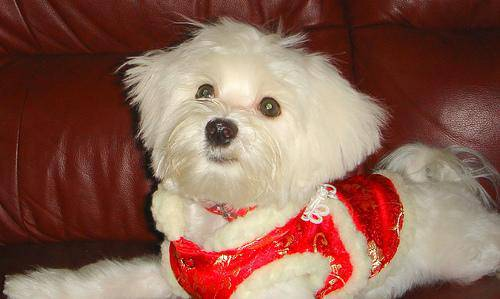

In [46]:
image

In [47]:
image.max(), image.min()

(255, 0)

In [48]:
# Turn image into tensors
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[111,  56,  51],
        [106,  51,  46],
        [114,  59,  54],
        ...,
        [ 76,  25,  21],
        [ 76,  25,  21],
        [ 76,  25,  21]],

       [[100,  45,  40],
        [102,  47,  42],
        [108,  53,  48],
        ...,
        [ 75,  24,  20],
        [ 75,  24,  20],
        [ 75,  24,  20]]], dtype=uint8)>

In [49]:
image[:2]

array([[[111,  56,  51],
        [106,  51,  46],
        [114,  59,  54],
        ...,
        [ 76,  25,  21],
        [ 76,  25,  21],
        [ 76,  25,  21]],

       [[100,  45,  40],
        [102,  47,  42],
        [108,  53,  48],
        ...,
        [ 75,  24,  20],
        [ 75,  24,  20],
        [ 75,  24,  20]]], dtype=uint8)

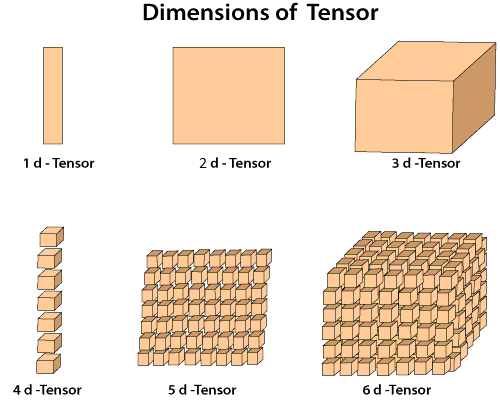

Three primary attributes define a tensor:

1. **Rank** :  Refers to the tensor’s number of axes
2. **Shape** :  Refers to the number of dimensions along each axis
3. **Datatype**

Example: A tensor of rank 3 may have (3, 5, 8) dimensions.

Now we've seen how an image looks like as a Tensor. Let's make a function to preprocess them:

https://www.tensorflow.org/tutorials/load_data/images

- Take an image filepath as input
- Use Tensorflow to read the file and save it to a variable, `image`
- Turn our `image`(a jpg) into Tensors
- Normalize image (convert color channel values from 0-255 to 0-1)
- Resize the `image` to be a shape of (224,224)
- Return the modified `image`

In [50]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing
def process_image(image_path,img_size=IMG_SIZE):
    '''
    Takes an image file path and turns it into a tensor
    '''

    # Read the image file
    image = tf.io.read_file(image_path)

    # Turn the .jpeg image into numerical tensor with 3 colours channel (RGB)
    image = tf.image.decode_jpeg(image,channels=3)

    # Convert the colour channel values from 0-255 to 0-1 => Normalization
    image = tf.image.convert_image_dtype(image,tf.float32)

    # Resize the image to our desired value(224,224)
    image = tf.image.resize(image, size=[IMG_SIZE,IMG_SIZE])

    return image

In [51]:
tensor = tf.io.read_file(filenames[26])
# tensor

In [52]:
tf.image.decode_jpeg(tensor,channels=3)

<tf.Tensor: shape=(500, 375, 3), dtype=uint8, numpy=
array([[[ 59,  68,  65],
        [ 64,  73,  70],
        [ 71,  80,  77],
        ...,
        [115, 128, 108],
        [115, 128, 108],
        [110, 123, 103]],

       [[ 65,  74,  71],
        [ 72,  81,  78],
        [ 79,  88,  85],
        ...,
        [114, 127, 107],
        [117, 130, 110],
        [116, 129, 109]],

       [[ 68,  77,  74],
        [ 76,  85,  82],
        [ 83,  92,  89],
        ...,
        [114, 127, 107],
        [120, 133, 113],
        [123, 136, 116]],

       ...,

       [[173, 200, 155],
        [164, 179, 136],
        [181, 166, 133],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[142, 159, 117],
        [147, 154, 113],
        [189, 174, 141],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[167, 179, 139],
        [167, 172, 132],
        [204, 188, 155],
        ...,
        [255, 255, 25

In [53]:
tf.image.convert_image_dtype(image,tf.float32)

<tf.Tensor: shape=(299, 500, 3), dtype=float32, numpy=
array([[[0.43529415, 0.21960786, 0.20000002],
        [0.4156863 , 0.20000002, 0.18039216],
        [0.44705886, 0.23137257, 0.21176472],
        ...,
        [0.29803923, 0.09803922, 0.08235294],
        [0.29803923, 0.09803922, 0.08235294],
        [0.29803923, 0.09803922, 0.08235294]],

       [[0.3921569 , 0.1764706 , 0.15686275],
        [0.40000004, 0.18431373, 0.16470589],
        [0.42352945, 0.20784315, 0.18823531],
        ...,
        [0.29411766, 0.09411766, 0.07843138],
        [0.29411766, 0.09411766, 0.07843138],
        [0.29411766, 0.09411766, 0.07843138]],

       [[0.41176474, 0.19607845, 0.1764706 ],
        [0.43137258, 0.21568629, 0.19607845],
        [0.4156863 , 0.20000002, 0.18039216],
        ...,
        [0.28235295, 0.09019608, 0.07058824],
        [0.28235295, 0.09019608, 0.07058824],
        [0.28235295, 0.09019608, 0.07058824]],

       ...,

       [[0.18039216, 0.08627451, 0.08627451],
        [0.16

#### Batch Size

The `batch size` is the number of input data values that you are introducing at once in the model.

It is very important while training, and secondary when testing.
For a standard Machine Learning/Deep Learning algorithm, choosing a batch size will have an impact on several aspects:

- The bigger the batch size , the more data you will feed at once in a model.
Thus, RAM memory consumption will be almost linear with batch size, and there will always be a limit based on your system specs and the size of your model above which your model will overflow.

- The bigger the batch size , the faster you will loop over your dataset N times to perform training.

- A bigger batch size will slow down your model training speed , meaning that it will take longer for your model to get one single update since that update depends on more data.

- A bigger batch size will have more data to average towards the next update of the model, hence training 8 should be smoother: smoother training/test accuracy curves.

Note that the size of the data is only related to the batch size in the sense that the bigger the data, the smaller the maximum batch size becomes (limit set by RAM).

The size of the model also has a similar relation.

In practice, you should `follow "in powers of 2 and the larger the better, provided that the batch fits into your (GPU) memory"`.

#### **Turning our data into batches**

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So, that's why we do about 32 (batch size) images at a time (We can manually adjust the batch size if need be)

In order to use tensorflow effectively, we need our data in the form of Tensor tuples which look like this:
`(image,label)`

In [54]:
# Create a simple function to return a tuple of tensors
def get_image_label(image_path,label):
    '''
        Takes an image path name and the associated label,
        processes the image and return a tuple of (image,label)
    '''
    image = process_image(image_path)
    return image,label

In [55]:
(process_image(X[42]),tf.constant(y[42])) # X = filenames, y = boolean_labels

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now, we have our data in tuples of tensors `(image,labels)`

Let's make a function to turn all our data (`X` and `y`) into batches

In [56]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size = BATCH_SIZE, valid_data = False, test_data=False):
    '''
        Create batches of data out of image (X) and label (y) pairs.
        Shuffles the data if it's training data but doesn't shuffles if it's validation data.
        Also accepts test data as input (no labels)
    '''

    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only file paths no labels
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch

    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print('Creating validation data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                  tf.constant(y))) # labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    else:
        print('Creating training data batches...')
        # Turn filepaths and labels into tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                  tf.constant(y))) # labels
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))
         # Create (image,label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)
        data_batch = data.batch(BATCH_SIZE)
        return data_batch


In [57]:
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [58]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec # Image, label pairs for each

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

#### Vizualising Data Batches
Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize the data

In [59]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images,labels):
    '''
        Displays a plot of 25 images and their labels from a data batch
    '''

    # Setup the figure
    plt.figure(figsize=(10,10))
    for i in range(25):

        # Create subplots(5 rows and 5 columns)
        ax = plt.subplot(5,5,i+1)

        # Display an image
        plt.imshow(images[i])

        # Add the image label as title
        plt.title(unique_breeds[labels[i].argmax()])

        # Turn the grid lines off
        plt.axis("off")

In [60]:
unique_breeds[y[0].argmax()]

'boston_bull'

In [61]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

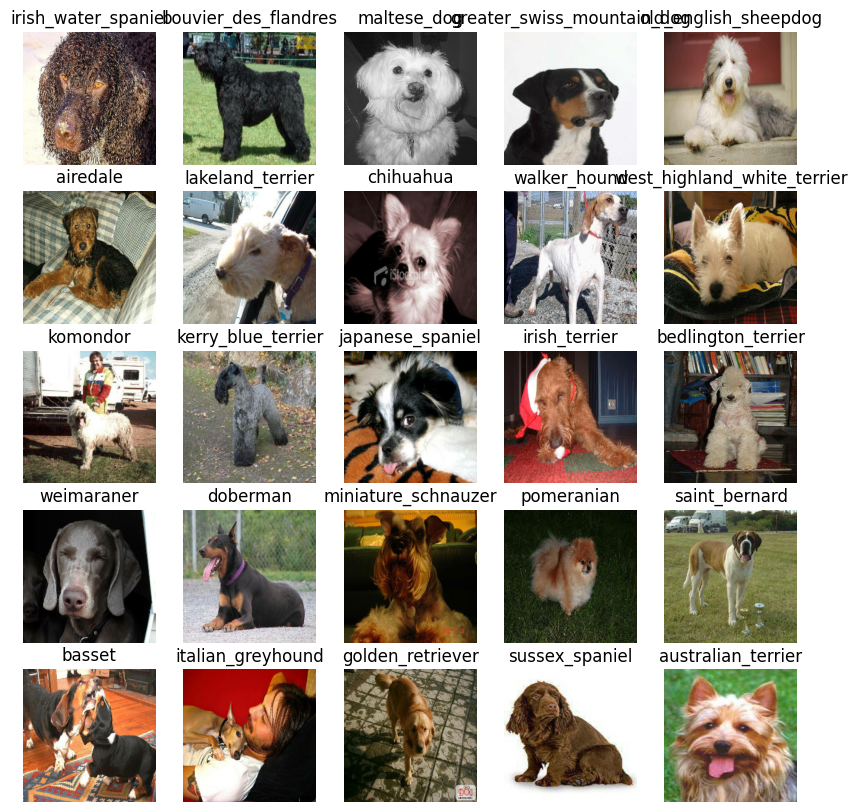

In [62]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

In [63]:
len(train_images), len(train_labels)

(32, 32)

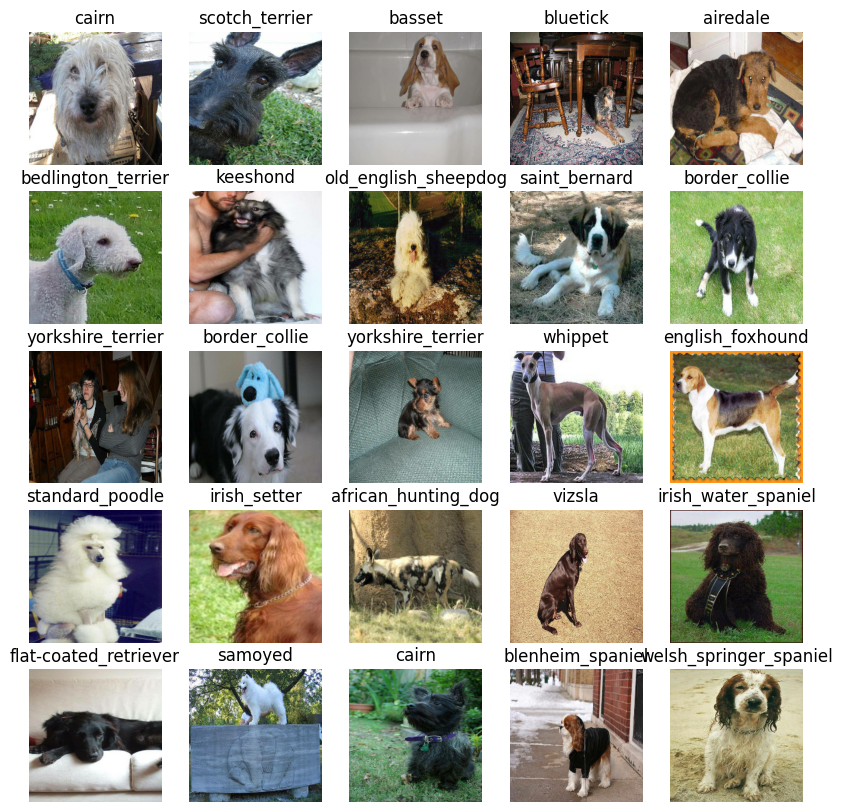

In [64]:
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

# Building our model

Before we build a model, there are a few things we need to define

- Input shape (our images' shape, in form of tensors) to our model
- Output shape (image labels, in the form of tensors) of our model
- The URL of the model we want to use from Tensorflow HUB (https://www.tensorflow.org/hub/tutorials)

In [65]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color_channels

# Setup output shape of the output
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from Tensorflow HUB
MODEL_URL = "https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/large-075-224-classification/1"

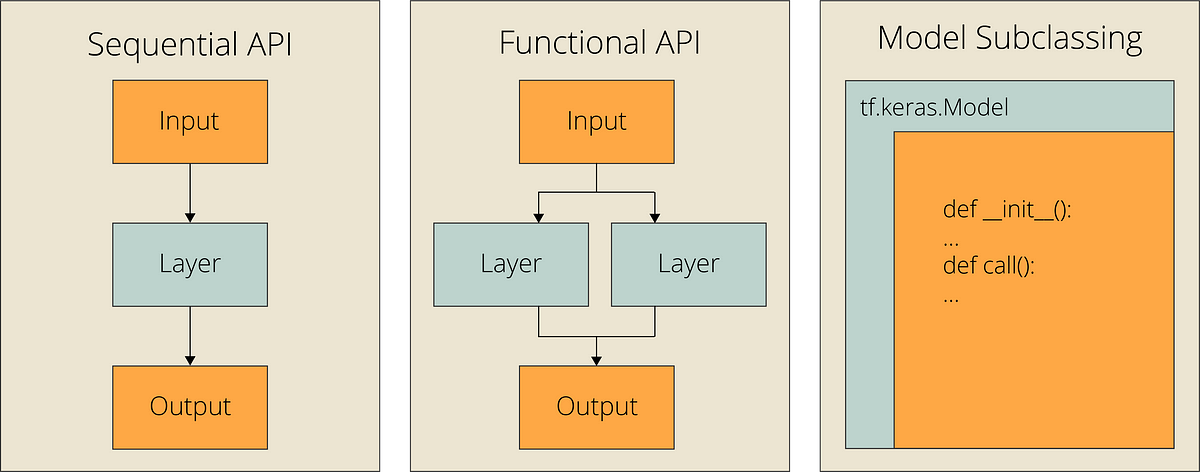

Now we have inputs and outputs and model ready to go.
Let's put them together!!

Let's create a function which:
- Takes the input shape, output shape and the model we've chosen as parameters
- Define the layers in a Keras model in sequential fashion
- Compiles the model (says it should be evaluated and improved)
- Builds the model (tells the model the input shape it'll be getting)
-  Returns the model

All of these steps can be found here:
https://www.kaggle.com/models/google/mobilenet-v3

In [66]:
from tensorflow import keras
from keras import layers

# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url = MODEL_URL):
    print("Building model with: ", MODEL_URL)

    # Setup the model layers
    model = tf.keras.Sequential([
            hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
            tf.keras.layers.Dense(units=OUTPUT_SHAPE,
            activation="softmax") # Layer 2 (output layer)
    ])

    # Compile the model
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(), # Loss is the height of the hill, we want to min. the height
        optimizer = tf.keras.optimizers.Adam(),
        metrics = ['accuracy']
    )

    # Build the model
    model.build(INPUT_SHAPE)

    return model

In [67]:
model = create_model()
model.summary()

Building model with:  https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/large-075-224-classification/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              4013897   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 4134137 (15.77 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 4013897 (15.31 MB)
_________________________________________________________________


#### Keras API components
1. **Layers** : Layers are the basic building blocks of neural networks in Keras. A layer consists of a tensor-in tensor-out computation function and some state, held in TensorFlow variables (the layer's weights).
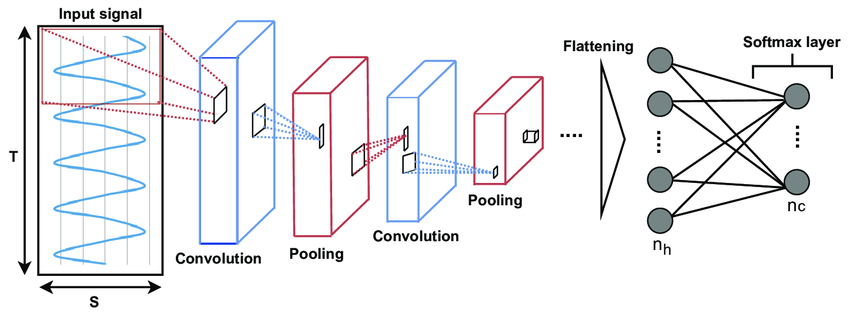

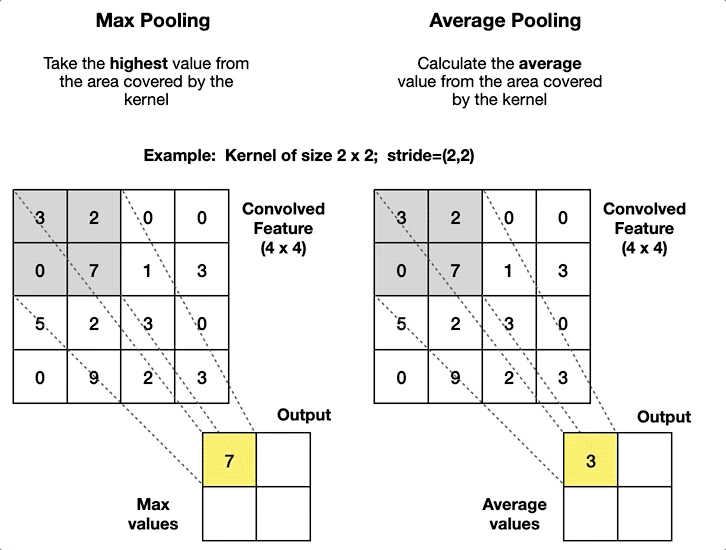

2. **Models** : A model is an object that groups layers together and that can be trained on data.

`Compiling` the model means configuring the learning process. It's where we define the optimizer, loss function, and metrics that we want to use. The **optimizer** is the algorithm that adjusts the weights of the network to minimize the loss function.

An **activation function** is a mathematical function that is applied to the output of a neuron. It determines whether a neuron should be activated or not, and thereby if the node should contribute to the calculations of the network or not.

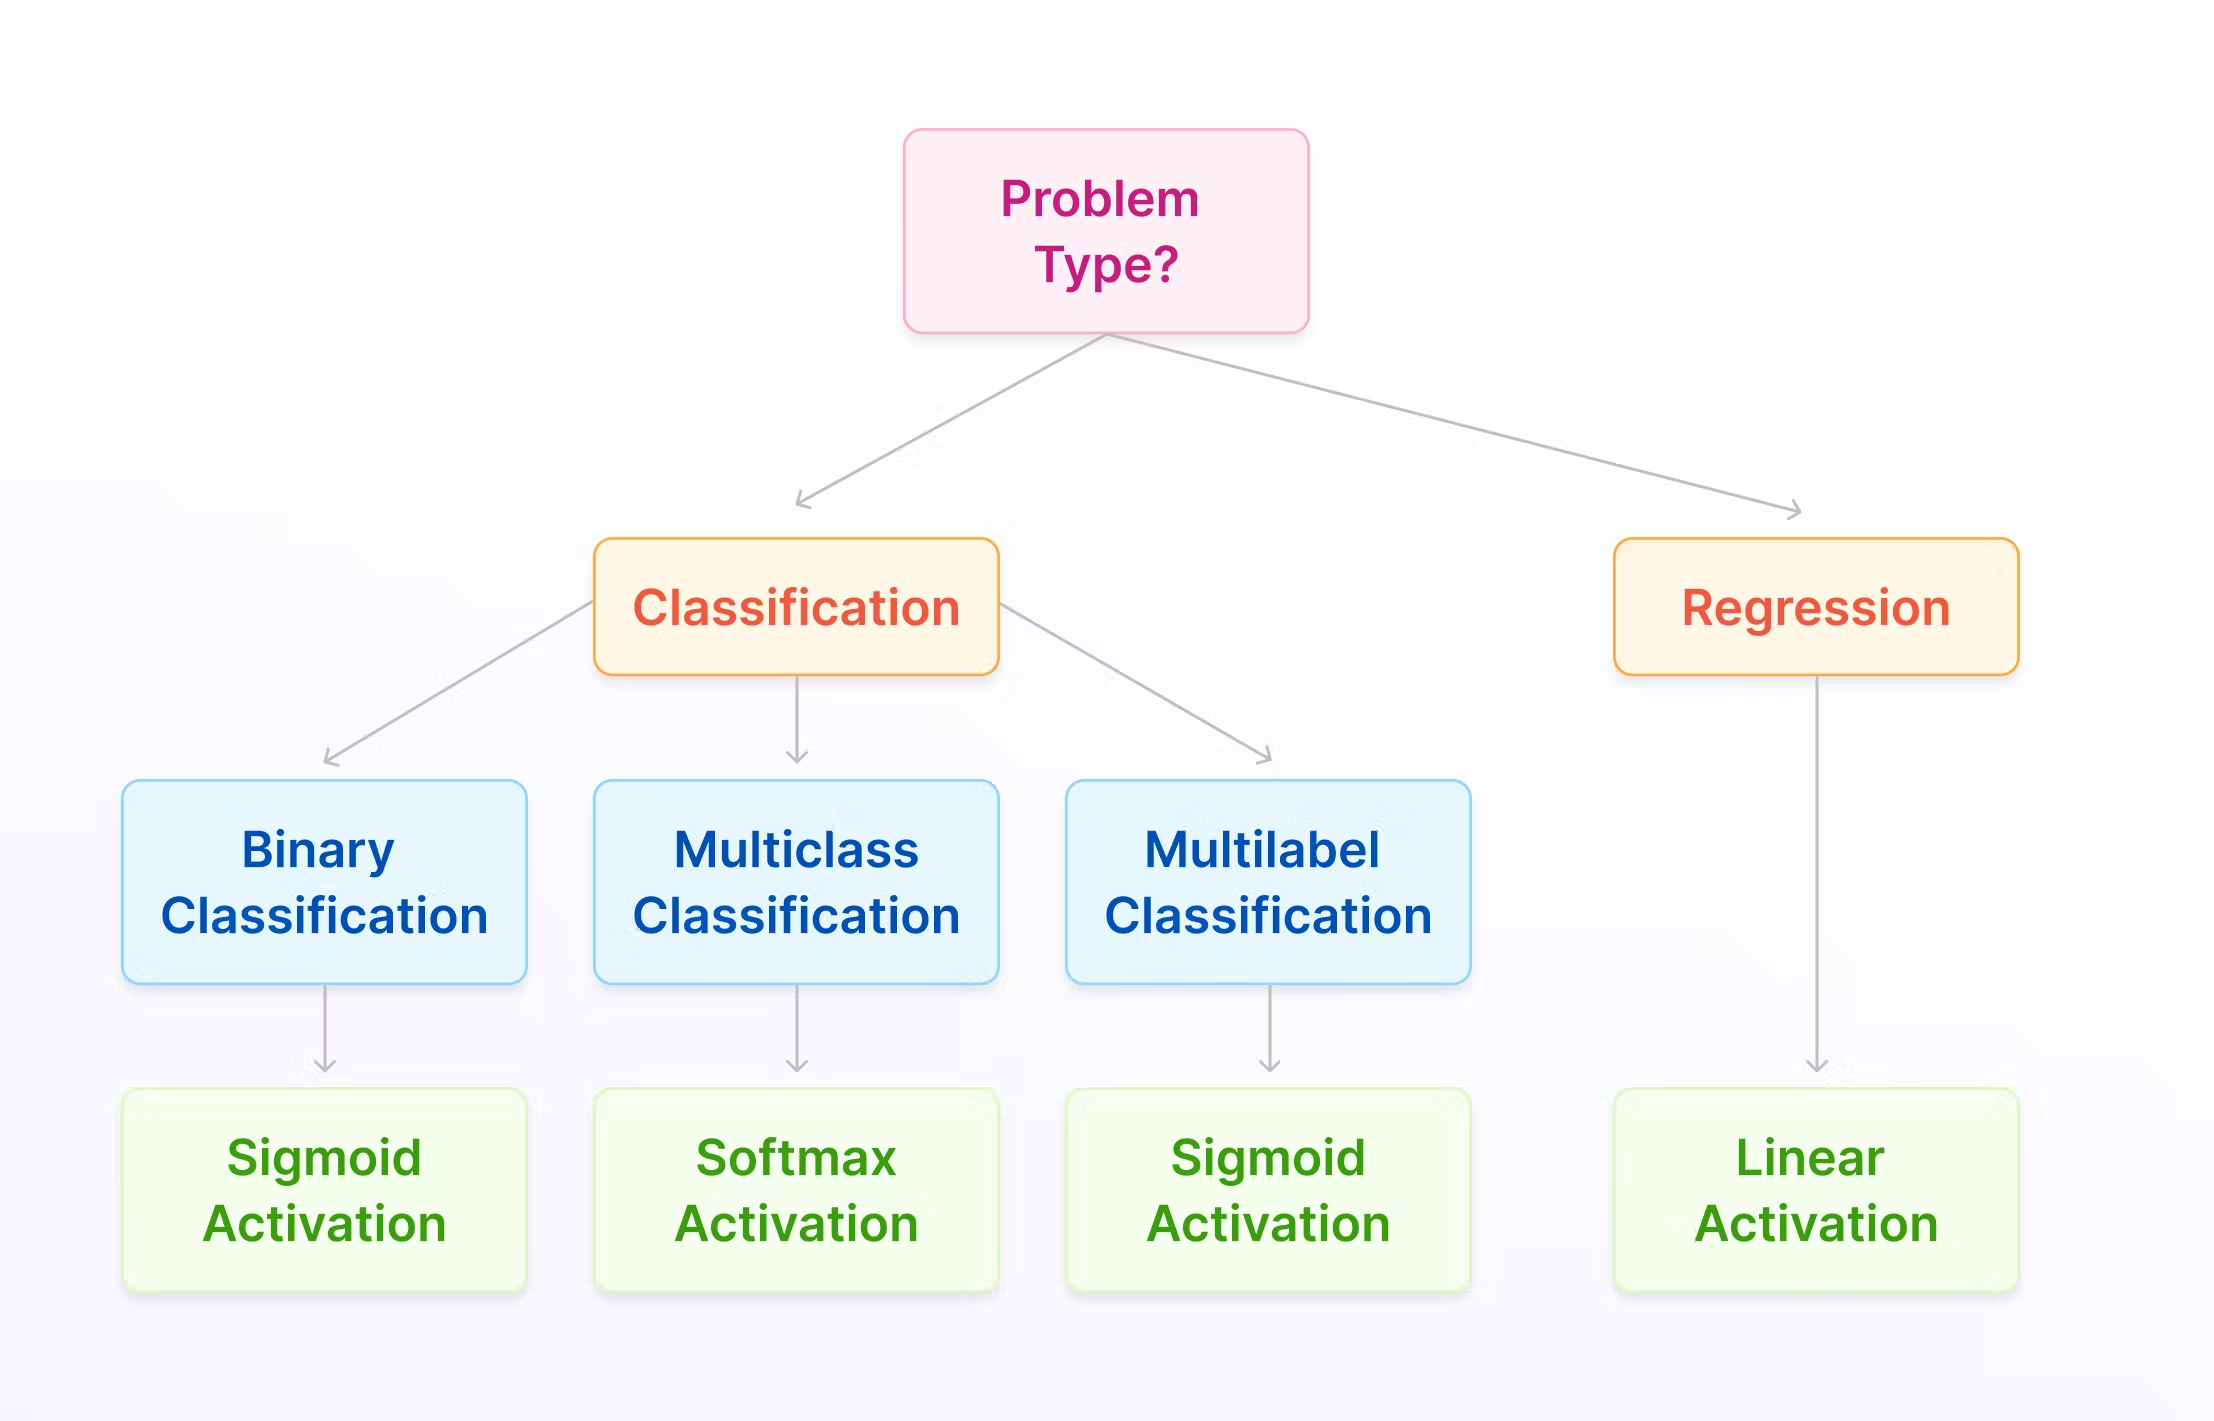

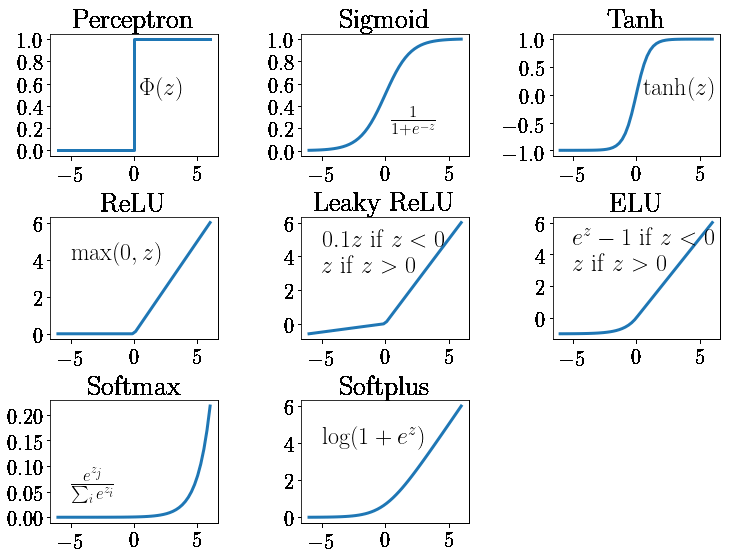

A **dense layer** is a classic fully connected neural network layer : every output depends on every input.

A **dropout layer** is similar except that when the layer is used, the activations are set to zero for some random nodes. This is a way to prevent overfitting.

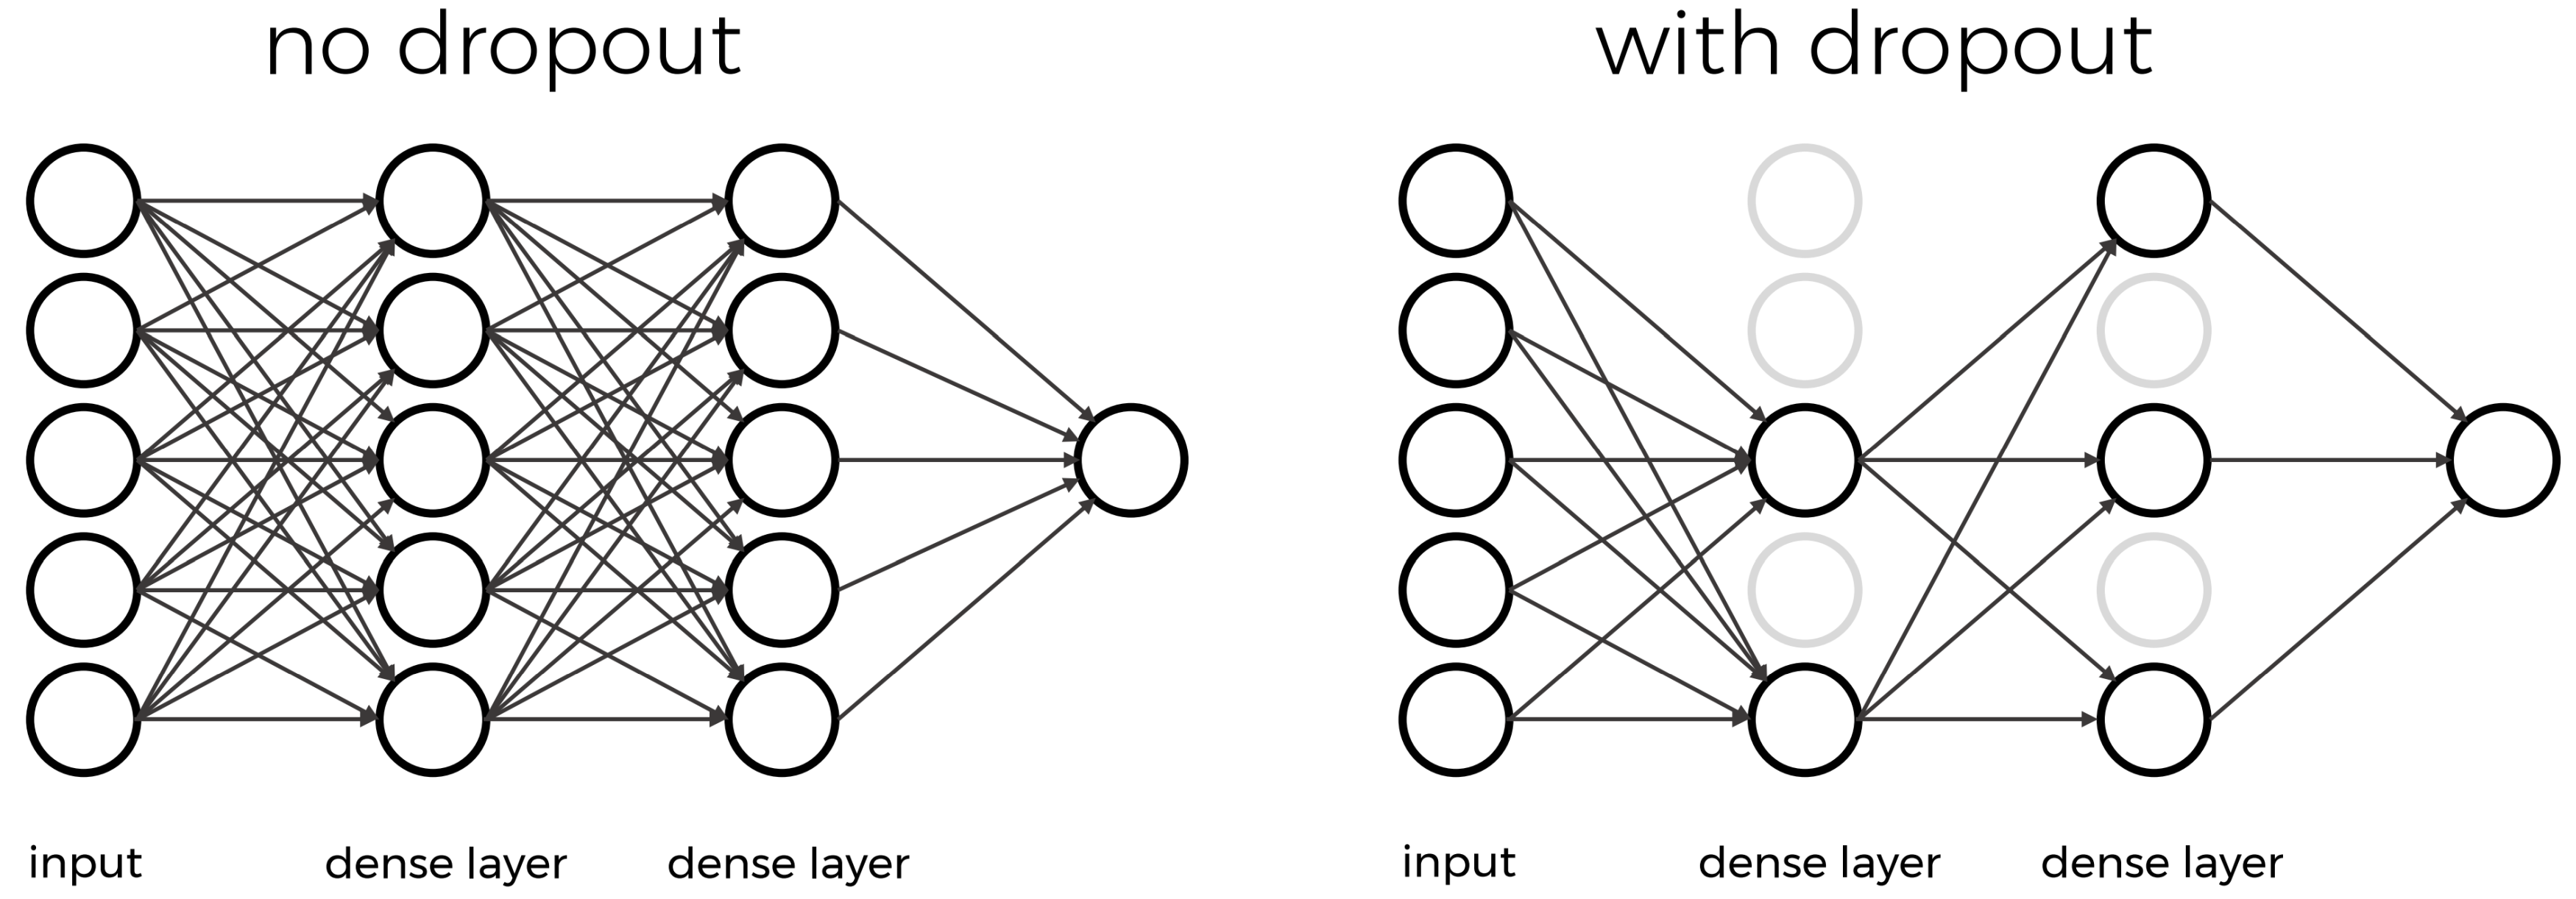

**Bias** is a constant value that is `added to the product of features and weights`. It's similar to the intercept in a linear equation, and it helps the model fit the data better.

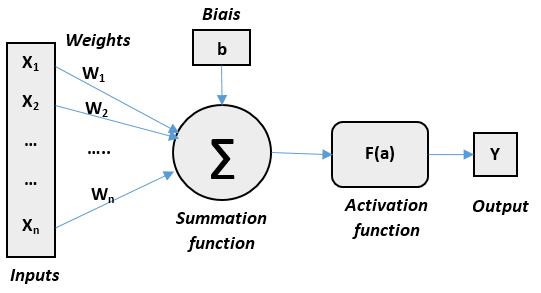

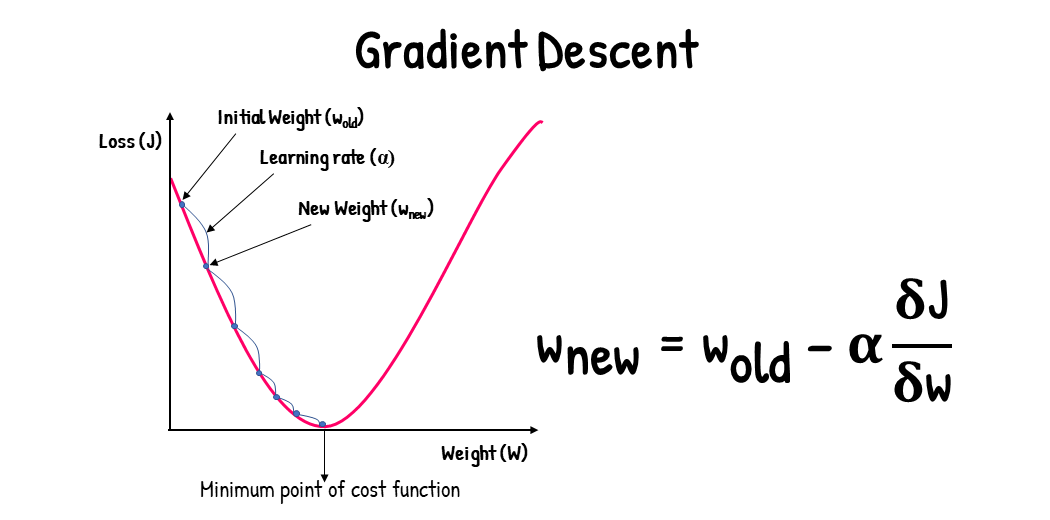

In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              4013897   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 4134137 (15.77 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 4013897 (15.31 MB)
_________________________________________________________________


#### Creating callbacks
Callbacks are helper functions a model can use during training to do such things as save its progress, check it's progress or stop training early if a model stops learning.

We'll create two callbacks, one for TensorBoard which helps track our model progess and another for early stopping which prevents our model from training too long.

#### TensorBoard
To setup a tensorboard callback, we need to do 3 things:
1. Load the tensorboard notebook extension
2. Create a tensorboard callback which is able to save logs to a directory and pass it to our model's `fit()` function
3. Visualise our models training logs with the `%tensorboard` magic function (We'll do this after model training)

In [69]:
# Load TensorBoard notebook magic extension
%load_ext tensorboard

In [70]:
import datetime

# Create a function to build a tensorboard callback

def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join("/content/drive/MyDrive/Dog_Vision/logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

    return tf.keras.callbacks.TensorBoard(logdir)


#### Preventing Overfitting

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

- Early stopping callback


In [71]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3) # No. of epochs with no improvement after which training will be stopped

#### Training our model (on subset of the data)

Our first model is only going to train on 1,000 images, to make sure everything is working.

In [72]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [73]:
# Check for GPU availability
print("GPU", "available") if tf.config.list_physical_devices("GPU") else "Not available"

'Not available'

Let's create a function which trains a model

- Create a model using `create_model()`
- Setup a TensorBoard callback using `create_tensorboard_callback()`
- Call the `fit()` function on our model passing it the training data, validation data, no. of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
- Return the model

In [74]:
# Build a function to train and return a trained model
def train_model():
    '''
    Trains a given model and returns the trained version
    '''
    # Create a model
    model = create_model()

    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
              epochs=NUM_EPOCHS,
              validation_data=val_data,
             validation_freq=1,
              callbacks=[tensorboard, early_stopping])
    return model

In [ ]:
# Fit the model to the data
model = train_model()

Building model with:  https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/large-075-224-classification/1
Epoch 1/100
25/25 [==============================] - 257s 6s/step - loss: 4.8330 - accuracy: 0.0587 - val_loss: 3.7384 - val_accuracy: 0.2200
Epoch 2/100
25/25 [==============================] - 37s 2s/step - loss: 1.8237 - accuracy: 0.6513 - val_loss: 2.5610 - val_accuracy: 0.4250
Epoch 3/100
25/25 [==============================] - 35s 1s/step - loss: 0.6175 - accuracy: 0.9275 - val_loss: 2.1209 - val_accuracy: 0.5050
Epoch 4/100
25/25 [==============================] - 33s 1s/step - loss: 0.2642 - accuracy: 0.9862 - val_loss: 1.9353 - val_accuracy: 0.5500
Epoch 5/100
25/25 [==============================] - 28s 1s/step - loss: 0.1414 - accuracy: 1.0000 - val_loss: 1.8592 - val_accuracy: 0.5650
Epoch 6/100
25/25 [==============================] - 29s 1s/step - loss: 0.0944 - accuracy: 1.0000 - val_loss: 1.8283 - val_accuracy: 0.5700
Epoch 7/100
25/25 [===================

#### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize it's content

In [ ]:
%tensorboard --logdir drive/My\ Drive/Dog_Vision/logs

#### Making and evaluating predictions using a trained model

In [ ]:
val_data

In [ ]:
# Make prediction on the validation data (not used to train on)
predictions = model.predict(val_data,verbose=1)
predictions

In [ ]:
predictions.shape

In [ ]:
predictions[0] # Probability value, that model thinks about each breed

In [ ]:
np.sum(predictions[0])

In [ ]:
len(predictions[0])

In [ ]:
len(y_val)

In [ ]:
len(unique_breeds)

In [ ]:
predictions[1]

In [ ]:
np.sum(predictions[1])

In [ ]:
# predictions[199]

In [ ]:
np.sum(predictions[199])

In [ ]:
# First prediction
index = 7
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}") # Higher it is, more confident the model is
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

In [ ]:
unique_breeds[82]